In [ ]:
# Environment setup
#!pip install scikit-learn opencv-python-headless matplotlib pandas

# Dataset
#!wget https://data.lhncbc.nlm.nih.gov/public/Pills/rximage.zip -O rximage.zip
#!unzip rximage.zip -d rximage

In [47]:
from pyspark.sql import SparkSession


spark = SparkSession.builder \
    .appName("RxImageAnalysis") \
    .config("spark.driver.memory", "16g") \
    .config("spark.executor.memory", "16g") \
    .config("spark.executor.instances", "15") \
    .getOrCreate()


In [54]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, when, coalesce

spark = SparkSession.builder.getOrCreate()

# loading CSV
csv_path = '/expanse/lustre/projects/uci150/arodriguez6/rximage/table.csv'
df = spark.read.option("header", True).csv(csv_path)

image_cols = [
    "RXNAV 120", "RXNAV 300", "RXNAV 600",
    "RXNAV 800", "RXNAV 1024", "RXNAV ORIGINAL"
]

# at least one image path exists
image_exists_condition = None
for c in image_cols:
    condition = col(c).isNotNull()
    image_exists_condition = condition if image_exists_condition is None else (image_exists_condition | condition)

df_valid = df.filter(col("name").isNotNull() & (col("name") != "NULL") & image_exists_condition)

print(f"Valid entries with at least one image and label: {df_valid.count()}")

Valid entries with at least one image and label: 4332


In [55]:
df.printSchema()
df.show(5)

root
 |-- ndc11: string (nullable = true)
 |-- rxcui: string (nullable = true)
 |-- name: string (nullable = true)
 |-- rxnavImageObjectId: string (nullable = true)
 |-- rxnavImageFileName: string (nullable = true)
 |-- nlmImageFileName: string (nullable = true)
 |-- RXNAV 120: string (nullable = true)
 |-- RXBASE 120: string (nullable = true)
 |-- RXNAV 300: string (nullable = true)
 |-- RXBASE 300: string (nullable = true)
 |-- RXNAV 600: string (nullable = true)
 |-- RXBASE 600: string (nullable = true)
 |-- RXNAV 800: string (nullable = true)
 |-- RXBASE 800: string (nullable = true)
 |-- RXNAV 1024: string (nullable = true)
 |-- RXBASE 1024: string (nullable = true)
 |-- RXNAV ORIGINAL: string (nullable = true)
 |-- RXBASE ORIGINAL: string (nullable = true)

+-------------+------+--------------------+------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------------

In [56]:
# Count how many image paths per resolution excluding null 
res_counts = df_valid.select([
    count(when(col(c).isNotNull(), c)).alias(c.replace("RXNAV ", "res_")) for c in image_cols
])
res_counts.show()

# Cpint how many image paths per resolution are null
missing_counts = df_valid.select([
    count(when(col(c).isNull(), c)).alias(f"missing_{c.replace(' ', '_')}") for c in image_cols
])
missing_counts.show()




+-------+-------+-------+-------+--------+------------+
|res_120|res_300|res_600|res_800|res_1024|res_ORIGINAL|
+-------+-------+-------+-------+--------+------------+
|   4332|   4332|   4332|   4332|    4332|        4332|
+-------+-------+-------+-------+--------+------------+

+-----------------+-----------------+-----------------+-----------------+------------------+----------------------+
|missing_RXNAV_120|missing_RXNAV_300|missing_RXNAV_600|missing_RXNAV_800|missing_RXNAV_1024|missing_RXNAV_ORIGINAL|
+-----------------+-----------------+-----------------+-----------------+------------------+----------------------+
|                0|                0|                0|                0|                 0|                     0|
+-----------------+-----------------+-----------------+-----------------+------------------+----------------------+



In [61]:
label_counts = df_valid.groupBy("name").agg(count("*").alias("image_count")).orderBy(col("image_count").desc())
label_counts.show(15, truncate=False)

print(f"Total unique pill classes: {df_valid.select('name').distinct().count()}")

+------------------------------------------------------------------------------------------------------------------------------------------------------+-----------+
|name                                                                                                                                                  |image_count|
+------------------------------------------------------------------------------------------------------------------------------------------------------+-----------+
|pantoprazole 40 MG Delayed Release Oral Tablet                                                                                                        |10         |
|Lisinopril 5 MG Oral Tablet                                                                                                                           |9          |
|Simvastatin 5 MG Oral Tablet                                                                                                                          |9          |
|Lisinopri

/scratch/arodriguez6/job_39072309/ipykernel_474873/166847964.py:7: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


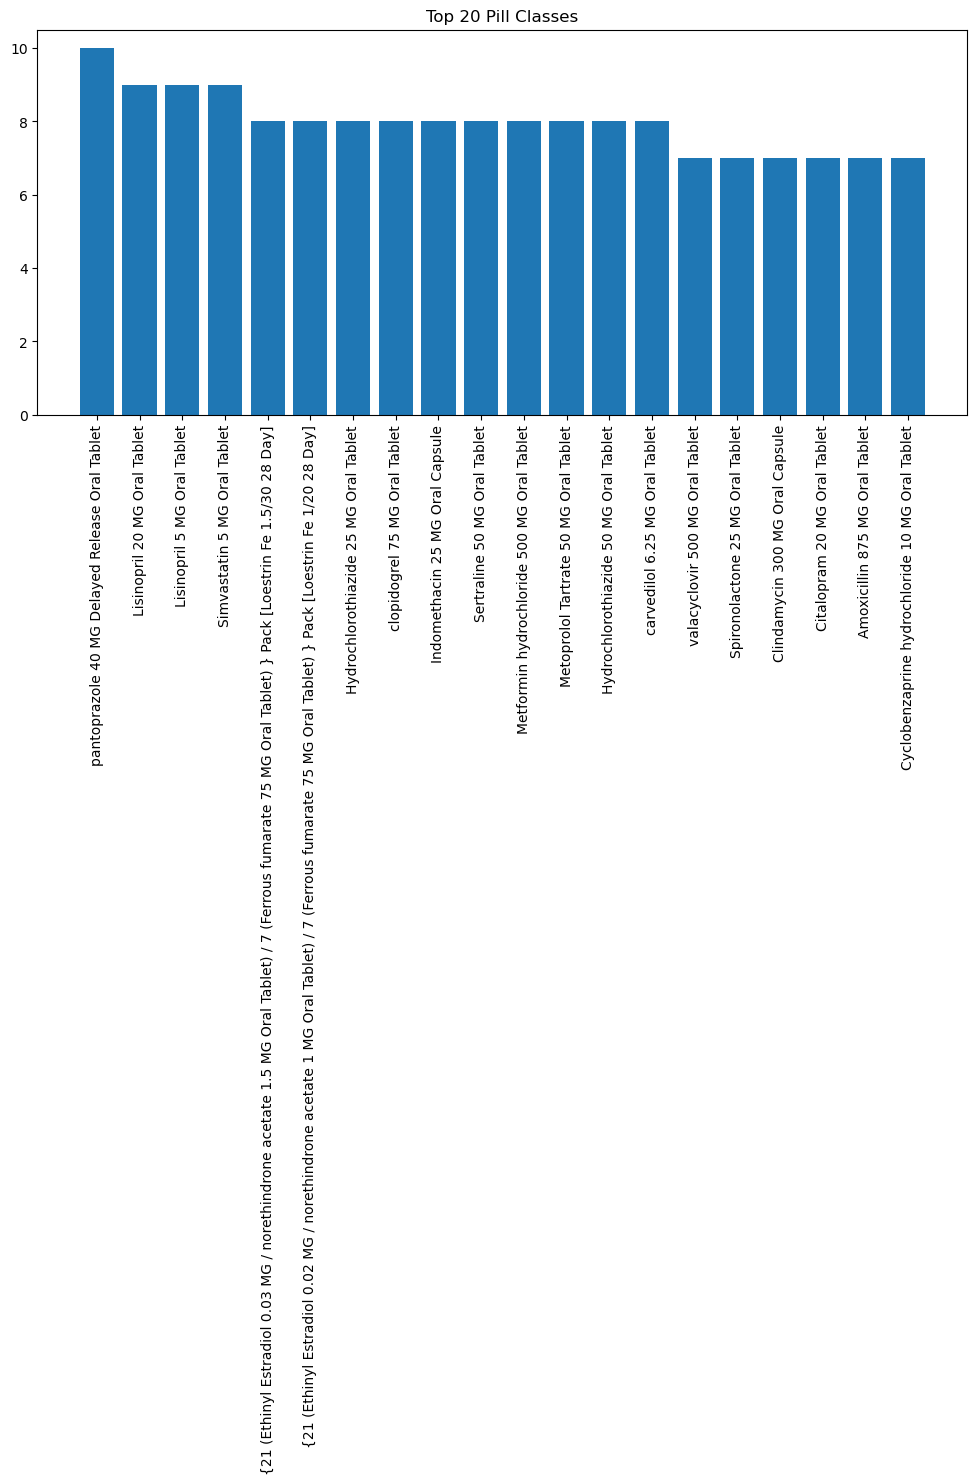

In [58]:
class_counts_pd = df_valid.groupBy('name').count().toPandas().sort_values('count', ascending=False)

plt.figure(figsize=(12, 5))
plt.bar(class_counts_pd['name'][:20], class_counts_pd['count'][:20])
plt.xticks(rotation=90)
plt.title('Top 20 Pill Classes')
plt.tight_layout()
plt.show()


In [59]:
from pyspark.sql.functions import coalesce, col

df_valid = df_valid.withColumn(
    "image_path",
    coalesce(
        col("RXNAV ORIGINAL"), col("RXNAV 1024"),
        col("RXNAV 800"), col("RXNAV 600"),
        col("RXNAV 300"), col("RXNAV 120")
    )
)


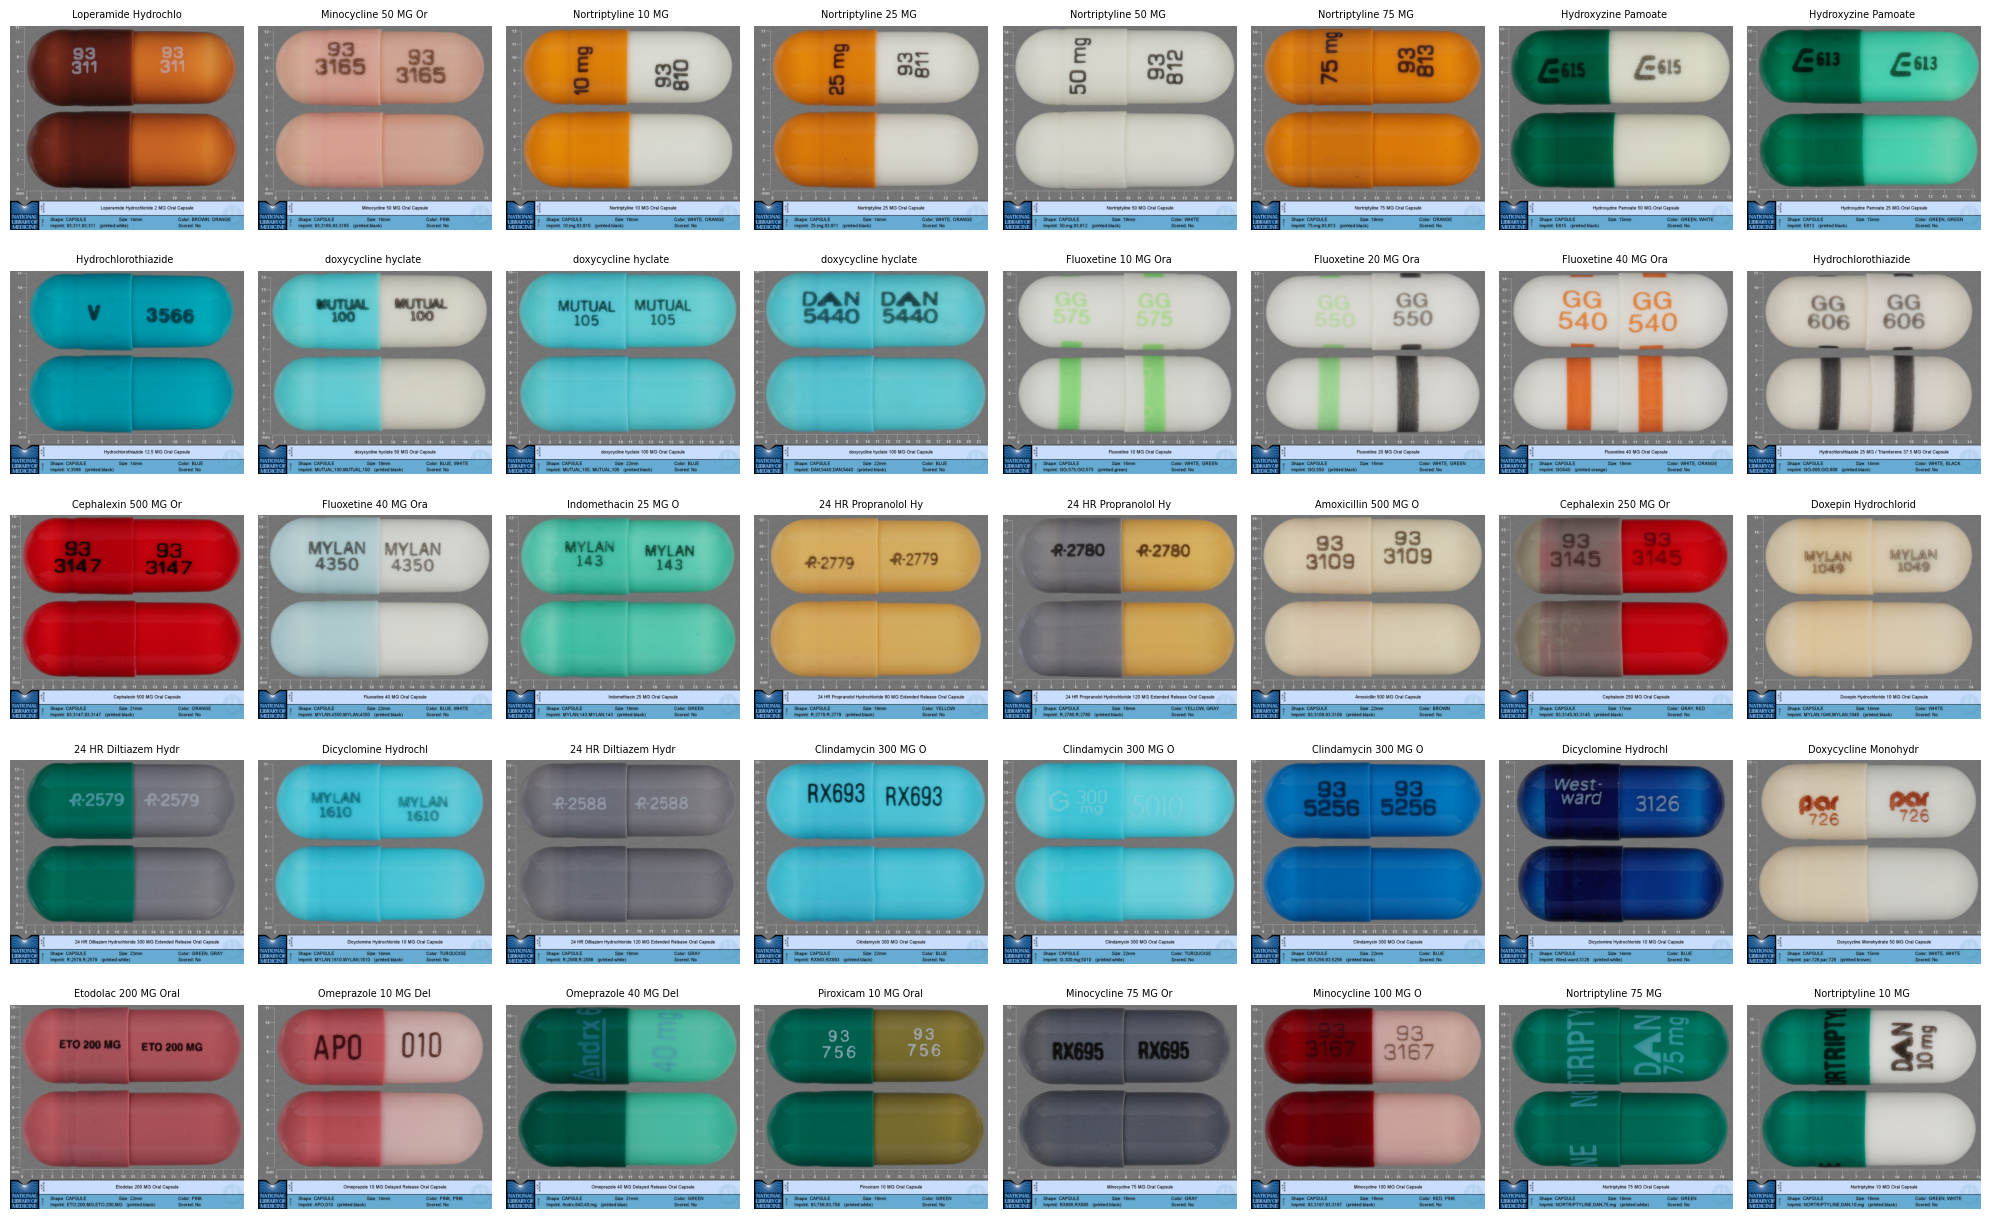

In [60]:
import matplotlib.pyplot as plt
from PIL import Image
import os
import math

# Get sample data
sample_pd = df_valid.select("name", "image_path").limit(40).toPandas()
res_path = '/expanse/lustre/projects/uci150/arodriguez6/rximage/'

num_samples = len(sample_pd)
cols = 8
rows = math.ceil(num_samples / cols)

plt.figure(figsize=(20, 2.5 * rows))
for i, row in sample_pd.iterrows():
    try:
        img = Image.open(os.path.join(res_path, row["image_path"]))
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.title(row["name"][:20], fontsize=7)
        plt.axis("off")
    except:
        continue

plt.tight_layout()
plt.show()
